<a href="https://colab.research.google.com/github/CristianMorasso/statistical_project/blob/master/Statistical_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistical Learning Project: ALFA Dataset Anaysis


## Setup:

### Download the dataset and parse the files

In [1]:
# Download the dataset from our git repository hosted on Github
!pip install scikit-learn polars numpy imbalanced-learn sktime matplotlib seaborn
!rm -rf statiscal_project
!git clone https://github.com/CristianMorasso/statistical_project.git

LEN_DATASET = 45

fatal: destination path 'statistical_project' already exists and is not an empty directory.


### Intro:

<!-- The project concerns the comparison of 3 different models (K-Nearest Neighbour, Convolutional Neural Network, Recurrent Neural Network) for a classification problem applied to the AirLab Failure and Anomaly (ALFA) Dataset. -->
Thanks to Artificial Intelligence, many industries have moved forward, such as automation, from autonomous agents capable of performing jobs with complete autonomy to autonomous driving, but a key part of any complex autonomous system is the ability to understand when an anomaly is occurring, so as to avoid any negative implications for work, robots and especially people.

Therefore, we decided to propose a comparison of Machine Learning (ML) models on a complex real-world task (classification on anomalies) such as the **AirLab Failure and Anomaly (ALFA) Dataset**, the idea is to compare some online models in order to show their **accuracy** and **inference speed**, crucial in online anomaly detection task. We are also performing some **state-of-the-art preprocessing** to recover the dataset from classical problems, such as missing values or unbalanced number of samples (time series) per class.

In this project we are using:
* Models:
  * KNearestNeighbors (KNN): very popular ML algorithm
  * Convolutional Neural Network (CNN): Most popular and used neural network
  * Recurrent Neural Network (RNN): Neural network suited for timeseries
* Algorithms:
  * SMOTE: State-of-the-art algorithm for data augmentation
  * Dynamic time warping (DTW): Metric to evaluate time series similarity

**Project Outline**
1. [Dataset](#scrollTo=L5LpPTEjx_Xw)
2. [Preprocess](#scrollTo=yYKZSxKI3cUq&line=1&uniqifier=1) (Unusable features and Inpute missing values)
3. [Split the dataset into windows](#scrollTo=tZORfFeIsTJz)
4. [Split Train and Test set](#scrollTo=E7mUlWl_beM2)
5. [Feature selection](#scrollTo=TygVNz4Q6jDl)
    1. SelectKBest form SKLearn
    2. RandomForest on Train
        * With error features
        * Without error features
6. [Rebalancing of the train dataset using SMOTE](#scrollTo=leFyfkeNE1xl)
7. [Testing Models](#scrollTo=U-rpr02NwwbN)
    * [KNeighborsTimeSeriesClassifier](#scrollTo=Ag6BQ6nSx_YC)
    * [Convolutional Neural Network (CNN)](#scrollTo=nNBkV-esx_YD)
    * [Recurrent Neural Network (RNN)](#scrollTo=dlvS8uX0x_YD)
8. [Model comparison](#scrollTo=4idEvTo0x_YF)
    * Confusion Matrix and Accuracy, Recall, Precision, F1


### Dataset


<img title="Autonomous flight example" width="500" src="https://github.com/CristianMorasso/statistical_project/blob/master/imgs/UAV.png?raw=1">

The [AirLab Failure and Anomaly (ALFA) Dataset](https://theairlab.org/alfa-dataset/) concerns several fault types in control surfaces of a fixed-wing Unmanned Aerial Vehicle (UAV) for use in Fault Detection and Isolation.

The data is collected using sensors, like GPS or wind estimation, local and global state (internal state of UAV). The platform used for collecting data is a custom modification of the Carbon Z T-28 model plane (shown in the figure above).

The failures can be:
* Engine
* Aileron (can be used as specific or generic)
* Ruddler (can be used as specific or generic)
* Elevator (can be used as specific or generic)

The dataset includes processed data for 45 sequences of fully autonomous flight sequences with different types of faults happening during the flights.


In [2]:
# Read the data from the csv files
import numpy as np
import pandas  as pd
import os
from random import shuffle

dataset_dir = "statistical_project/data"
dfs = [] # dataframe list
Y_fly = []

classToString= {0:"no_failure", 1:"elevator", 2:"engine", 3:"rudder",4:"ailerons"}

stringToClass = {}
for key, value in classToString.items():
  stringToClass[value] = key

series_counter = 0

for _, cl  in enumerate(os.listdir(dataset_dir)):
  path1 = os.path.join(dataset_dir, cl)

  # Get rid of files or bad dirs
  if not os.path.isdir(path1) or cl == "features":
    print(f"{cl} is not a dir or not useful!")
    continue

  for f in  os.listdir(path1):
    pathf = os.path.join(path1, f)
    df = pd.read_csv(pathf)

    # Fix the label field
    try:
      df["field.data"] = df["field.data"].apply(func=lambda x: stringToClass[cl] if int(x)>0 else 0)
      df = df.rename(columns={"field.data": "Y"})
    except:
      print(f"Error for {cl}")
      df["Y"]  = pd.Series([ 0 for _ in range(df.shape[0])])

    # Drop the time column!
    df = df.drop("%time", axis=1)

    # Save it
    Y_fly.append(stringToClass[cl])
    dfs.append(df)
    series_counter+=1

print(f"\nNumber of Time Series: {len(dfs)}")
assert len(dfs) == LEN_DATASET # We know the exact number from the repo

# Shuffle the array of dataframes for so that classes are not contiguous
shuffle(dfs)

README.md is not a dir or not useful!
Error for no_failure
Error for no_failure
Error for no_failure
Error for no_failure
Error for no_failure
Error for no_failure
Error for no_failure
Error for no_failure
Error for no_failure
features is not a dir or not useful!
__init__.py is not a dir or not useful!

Number of Time Series: 45


Text(0.5, 0.98, 'Showing dataset')

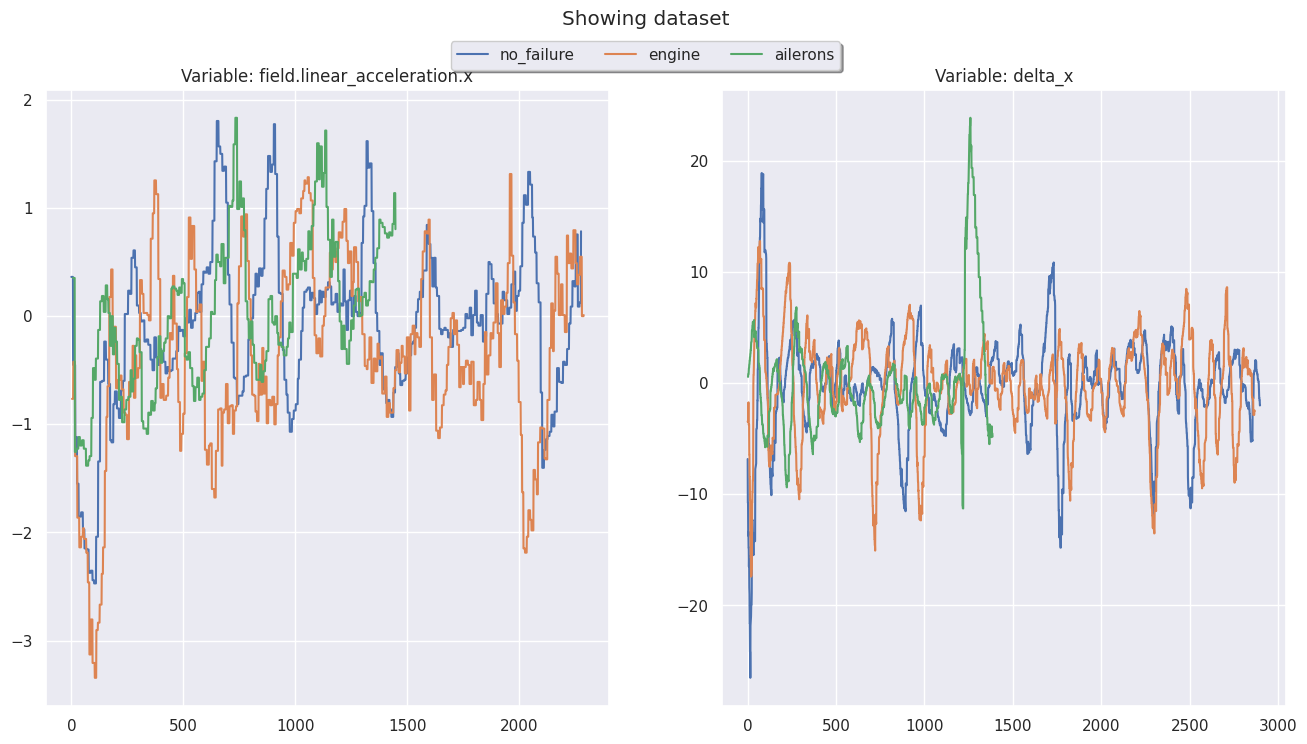

In [3]:
import matplotlib.pylab as plt
import seaborn as sns
Y_fly = np.array(Y_fly)
sns.set_theme()
sns.set_style()
fig, (left, right) = plt.subplots(1,2, figsize=(16,8))

left.plot(np.arange(dfs[np.where(Y_fly == 0)[0][0]]["delta_x"].shape[0]),dfs[np.where(Y_fly == 0)[0][0]]["field.linear_acceleration.x"] )
left.plot(np.arange(dfs[np.where(Y_fly == 2)[0][0]]["delta_x"].shape[0]),dfs[np.where(Y_fly == 2)[0][0]]["field.linear_acceleration.x"])
left.plot(np.arange(dfs[np.where(Y_fly == 4)[0][1]]["delta_x"].shape[0]),dfs[np.where(Y_fly == 4)[0][1]]["field.linear_acceleration.x"])
# plt.legend()
left.set_title("Variable: field.linear_acceleration.x")
right.plot(np.arange(dfs[np.where(Y_fly == 0)[0][2]]["delta_x"].shape[0]),dfs[np.where(Y_fly == 0)[0][2]]["delta_pitch"],label=classToString[0] )
right.plot(np.arange(dfs[np.where(Y_fly == 2)[0][2]]["delta_x"].shape[0]),dfs[np.where(Y_fly == 2)[0][2]]["delta_pitch"],label=classToString[2])
right.plot(np.arange(dfs[np.where(Y_fly == 4)[0][5]]["delta_x"].shape[0]),dfs[np.where(Y_fly == 4)[0][5]]["delta_pitch"],label=classToString[4])
right.set_title("Variable: delta_x")
fig.legend(loc="upper center", bbox_to_anchor=(0.5, .95),fancybox=True, shadow=True, ncol=3)
fig.suptitle("Showing dataset")
#trovare lunghezze corrette

### Remove unusable features and Inpute missing values

In [4]:
from sklearn.impute import SimpleImputer
import numpy as np

# Remove useless features and inpute missing values
#
# finally use the mask on every timeseries of the OG dataframes list

# Remove all the features that are not shared by all Time Series
#
# Only use the variables that can be found in all the dataframes
features = []
# Get the biggest set:
# (We are considering that that the bigger set is just a superset and has all the other base features)
for df in dfs:
   features = max(features, df.columns.values, key=lambda x: len(x))
# Then get the set intersection of all of the features sets
features = set(features)
for df in dfs:
  features = features.intersection(set(df.columns.values))

# Apply the feature mask
print(len(features))
dfs = list(map(lambda x: x[list(features)] , dfs))

# Concat all the time series in as single dataframe for later :)
concatted_dfs = pd.concat(dfs)
concatted_y = concatted_dfs["Y"]
concatted_dfs = concatted_dfs.drop("Y", axis=1)

26


In [5]:
from sklearn.impute import SimpleImputer
import numpy as np

# Inpute the missing values first
dfs = list(map(lambda x: SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(x) , dfs))

### Split the dataset into windows

We decided to split the time series in windows of size **10**  (and step size **10** so that the windows do not overlap).

We did this to increase the number of samples, but also to make the task **Online-friendly**. This way the models can be used in an rnline setting. Online classification is a really popular task for Time Series analysis and we though that it was the a good fit for the project.

In [6]:
from sktime.split import SlidingWindowSplitter

splitted_ndarrays, window_length, step_length = [], 10, 10
splitter = SlidingWindowSplitter(window_length=window_length, step_length=step_length)
splitted_ndarrays = [ list(map(lambda x: x[0], splitter.split_series(df))) for df in dfs] # We are ignoring the forecasting horizon

print(f"Length of windowed dataset: {len(splitted_ndarrays)}")
assert len(splitted_ndarrays) == LEN_DATASET

Length of windowed dataset: 45


In [7]:
# Split into windows
_splitted_ndarrays = []
_splitted_ys = []
features = list(features)
y_index = features.index("Y") # Index of the Y column
features.pop(y_index)
#features = ["flight", "step", *features]

i = 0 # Number of windows

for sa in splitted_ndarrays:
  for a in sa:

    # Retrieve the label and save it separately
    _splitted_ys.append(np.max(a[:,y_index]))
    # And then delete it
    a = np.delete(a, y_index, axis=1)

    # np.concatenate([flight, step, a], axis=1)
    _splitted_ndarrays.append(a)
    i+=1 # Increase window counter

assert len(_splitted_ys) == len(_splitted_ndarrays)
print("n_windows",len(_splitted_ndarrays))

n_windows 9342


### Split in Train and Test set

Class distribution Train: Counter({0.0: 6237, 2.0: 575, 4.0: 558, 3.0: 65, 1.0: 36})
Class distribution Test: Counter({0.0: 1560, 2.0: 144, 4.0: 140, 3.0: 17, 1.0: 10})


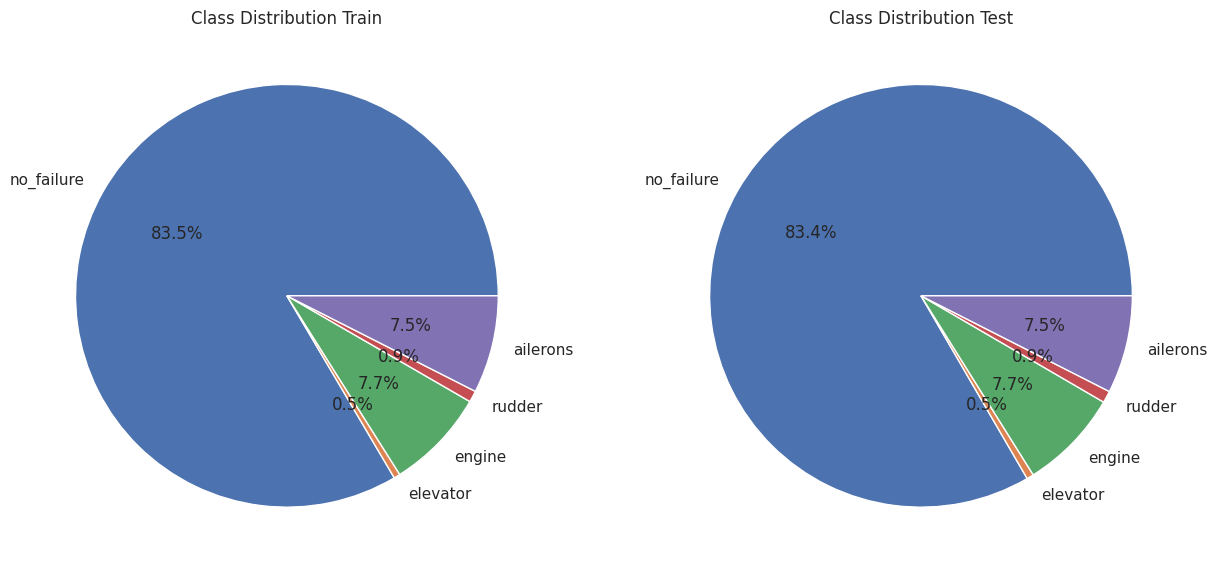

In [8]:
import math
from random import shuffle
import matplotlib.pyplot as plt
from collections import Counter

split = 0.8
zipped = list(zip(_splitted_ndarrays, _splitted_ys))

X_train, X_test = [], []
y_train, y_test = [], []
for val in classToString.keys():
  class_specific = list(filter(lambda x: x[1]==val, zipped))
  train_size = int(len(class_specific)*split)
  shuffle(class_specific)
  # Train Params for the class
  X_train += list(map(lambda x: x[0], class_specific[:train_size]))
  y_train += list(map(lambda x: x[1], class_specific[:train_size]))

  # Test Params for the class
  X_test  += list(map(lambda x: x[0], class_specific[train_size:]))
  y_test  += list(map(lambda x: x[1], class_specific[train_size:]))


print(f"Class distribution Train: {Counter(y_train)}")
print(f"Class distribution Test: {Counter(y_test)}")

# Plot the two pie graphs for the distributions
fig, (axTrain, axTest) = plt.subplots(1,2, figsize=(15,10))

train_dict = {classToString[item[0]]: item[1] for item in Counter(y_train).items()}
axTrain.pie(list(train_dict.values()), labels=list(train_dict.keys()),autopct='%1.1f%%')
axTrain.set_title("Class Distribution Train")

test_dict = {classToString[item[0]]: item[1] for item in Counter(y_test).items()}
axTest.pie(list(test_dict.values()), labels=list(test_dict.keys()), autopct='%1.1f%%')
axTest.set_title("Class Distribution Test")


# Switch to np.ndarray
y_train, y_test = np.array(y_train), np.array(y_test)

### Multi-Indexed Pandas Dataframe (sktime Panel)

In [9]:
feature_mask = [*features]

def toMultiIndexed(windows, feature_mask, start=0):
  _dfs = []
  for i, npVals in enumerate(windows):
    d = pd.DataFrame(npVals,columns=feature_mask)

    # The two columns for the multi-indexed Dataframe
    d.insert(0, "flight", [i + start for _ in range(int(npVals.shape[0]))], True, )
    d.insert(1, "step", pd.RangeIndex(int(npVals.shape[0])), True)
    d = d.set_index(["flight", "step"])

    _dfs.append(d)

  _dfs = pd.concat(_dfs)

  return _dfs

X_train, X_test = toMultiIndexed(X_train, features), toMultiIndexed(X_test, features)
feature_mask = ["flight", "step", *features]

In [10]:
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")
X_train.head(20)

X_train: (74710, 25)
X_test: (18710, 25)
y_train: (7471,)
y_test: (1871,)


delta_z  delta_roll  delta_pitch  field.aspd_error  \
flight step                                                        
0      0     2.157160   -4.554314    -1.247066       -749.273315   
       1     2.234844   -4.564312    -1.257066       -749.273315   
       2     2.288711   -4.574314    -1.677066       -734.940735   
       3     2.288711   -4.574314    -1.677066       -734.940735   
       4     2.398501   -2.594746    -1.834309       -734.940735   
       5     2.398501   -2.594746    -1.834309       -734.940735   
       6     2.424697   -2.584747    -1.804309       -734.940735   
       7     2.432463   -2.584747    -2.274309       -727.361084   
       8     2.440384   -2.604744    -2.264309       -727.361084   
       9     2.476444   -2.624744    -2.734309       -727.361084   
1      0     0.670387   -7.962153     2.129871        -29.142952   
       1     0.604053   -9.276568     2.386636        -26.263618   
       2     0.561113   -9.276568     2.386636        -26.263618   
       3     0.506981  -10.246568     2.266636        -16.804504   
       4     0.506202  -10.246568     2.256636        -16.804504   
       5     0.562312  -11.216568     2.276636        -30.426598   
       6     0.615424  -11.216568     2.276636        -30.426598   
       7     0.651243  -12.156568     2.356636        -49.347496   
       8     0.715936  -12.156568     2.356636        -49.347496   
       9     0.715936  -12.156568     2.356636        -49.347496   

             field.orientation.z  delta_roll_airspeed  field.twist.linear.x  \
flight step                                                                   
0      0               -0.822188            15.000000            -16.920471   
       1               -0.822188            15.000000            -16.920471   
       2               -0.856227            15.000000            -16.920471   
       3               -0.856227            15.000000            -16.920471   
       4               -0.856227            15.000000            -18.484636   
       5               -0.856227            15.000000            -18.484636   
       6               -0.856227            15.000000            -18.484636   
       7               -0.856227            15.000000            -18.484636   
       8               -0.856227            15.000000            -18.484636   
       9               -0.856227            15.000000            -19.832737   
1      0               -0.990425            -0.291430            -14.677399   
       1               -0.990425            -0.262636            -14.677399   
       2               -0.990425            -0.262636            -14.677399   
       3               -0.990425            -0.168045            -14.677399   
       4               -0.990425            -0.168045            -14.762954   
       5               -0.990425            -0.304266            -14.762954   
       6               -0.990425            -0.493475            -14.762954   
       7               -0.990425            -0.493475            -14.762954   
       8               -0.990425            -0.493475            -14.762954   
       9               -0.990425            -0.493475            -14.817412   

             field.linear_acceleration.y  field.xtrack_error  \
flight step                                                    
0      0                        0.892405           16.283470   
       1                        0.892405           16.283470   
       2                        0.490333           16.402901   
       3                        0.490333           16.402901   
       4                        0.490333           16.490108   
       5                        0.490333           16.490108   
       6                        0.490333           16.490108   
       7                        0.490333           16.588326   
       8                        0.490333           16.659916   
       9                        0.490333           16.659916   
1      0  

### Feature Selection

In [11]:
# Parameters for Feature selection
concatted_dfs = X_train.copy()
concatted_dfs.reset_index(drop=True, inplace=True)

concatted_y = []
for val in y_train.tolist():
  concatted_y += [val for _ in range(window_length)]
concatted_y = np.array(concatted_y)

concatted_dfs.head()
assert concatted_dfs.shape[0] == concatted_y.shape[0], "Not the same number of labels"

#### With SelectKBest
(Link [Here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html))

Descrizione

In [12]:
from sklearn.feature_selection import SelectKBest
import numpy as np

# Get the best 20 features of the dataset
columns_ = concatted_dfs.columns.values
feature_mask= SelectKBest(k=20).fit(concatted_dfs, concatted_y).get_feature_names_out(columns_)

print("Feature Mask:")
print(feature_mask)
print(f"Length of Feature Mask: {len(feature_mask)}")

Feature Mask:
['delta_z' 'delta_roll' 'delta_pitch' 'field.aspd_error'
 'field.orientation.z' 'delta_roll_airspeed' 'field.twist.linear.x'
 'field.linear_acceleration.y' 'field.xtrack_error'
 'field.linear_acceleration.z' 'delta_yaw' 'field.linear_acceleration.x'
 'field.orientation.x' 'field.alt_error' 'field.twist.linear.z'
 'field.orientation.y' 'field.angular_velocity.z' 'delta_y'
 'field.twist.linear.y' 'field.twist.angular.z']
Length of Feature Mask: 20


#### With randomForest scores:

**Random Forest** is a powerful ensemble learning method used in machine learning for classification and regression tasks. It operates by constructing multiple decision trees during training and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. This approach enhances the accuracy and robustness of the model by reducing overfitting and variance. Random Forest is also valuable for *feature selection*, as it provides a measure of feature importance, helping to identify the most relevant features in a dataset.

In [13]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

def plot_feature_importances(model):
    fig_scale = 0.9
    n_features = len(concatted_dfs.columns) # take the features names from the Concatted DataFrame
    plt.figure(figsize=(7*fig_scale,5.4*fig_scale))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), concatted_dfs.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)


##### With Error Columns:

In [14]:
# WITH ERROR COLUMNS:
#
concatted_ndarray = concatted_dfs.to_numpy()
rf = RandomForestClassifier()
rf.fit(concatted_ndarray, concatted_y)
# Plot the feature importances
plot_feature_importances(rf)

# Select the n best features
n = 20 # Removing 7 (the ones that are clearly not performing
couples = list(zip(concatted_dfs.columns, rf.feature_importances_))
couples.sort(key=lambda x: x[1])
accepted_features = list(map(lambda x: x[0], feature_mask[:n]))
feature_mask = ["flight", "step", *[c[0] for c in couples if (c[0] in accepted_features)] ]

KeyboardInterrupt: 

###### Without error columns:

In [ ]:
# WITHOUT ERROR COLUMNS:
#
concatted_dfs = concatted_dfs.drop(["field.alt_error", "field.xtrack_error", "field.aspd_error"], axis=1)
concatted_ndarray = concatted_dfs.to_numpy()
rf = RandomForestClassifier()
rf.fit(concatted_ndarray, concatted_y)
# Plot the feature importances
plot_feature_importances(rf)

# Select the n best features
n = 20 # Removing 7 (the ones that are clearly not performing
couples = list(zip(concatted_dfs.columns, rf.feature_importances_))
couples.sort(key=lambda x: x[1])
accepted_features = list(map(lambda x: x[0], feature_mask[:n]))
feature_mask = ["flight", "step", [c[0] for c in couples if (c[0] in accepted_features )]* ]

### Rebalancing:


#### K neighbours implementation for k-neighbours and no predict

We had to rewrite the algorithm because the SkTime version doesn't work right now (the function k_neighbours is broken and they are working on a fix).

In [15]:
import numpy as np

class DTW_KNN():
    def __init__(self, k=3):
        self.k = k
        self.data = None

    @staticmethod
    def dtw_distance(ts1: np.ndarray, ts2: np.ndarray):
      n, m = ts1.shape[0], ts2.shape[0]
      # Add one dimension up and on the left so we don't go out of bounds :)
      dtw_matrix = np.zeros((n+1, m+1))

      for i, row1 in enumerate(ts1, 1):
          for j, row2 in enumerate(ts2, 1):
              # L2 Norm == euclidian distance
              cost = np.linalg.norm(row1 - row2)

              # Get the previous smallest cost
              smaller = min(dtw_matrix[i-1, j],    # cell on the left
                            dtw_matrix[i, j-1],    # cell up
                            dtw_matrix[i-1, j-1])  # cell with the same idnex (diagonal, the best one for the shortest path)

              # And just keep the memory of the smallest path up to this position
              dtw_matrix[i, j] = cost + smaller

      return dtw_matrix[n, m]

    def fit(self, X: pd.DataFrame):
        self.data = X
        self.indexes = np.unique(X.index.get_level_values('flight').to_numpy()).tolist()

    def kneighbours(self, x: pd.DataFrame):
        index_distances= []
        x_index = x.index.get_level_values('flight')[0]

        x.reset_index(drop=True, inplace=True)
        x = x.to_numpy()

        # Let's just bruteforce this :)
        for index in self.indexes:
            # We can't keep x as a viable neighbour!
            if x_index == index: continue
            point = self.data.loc[index]
            point.reset_index(drop=True, inplace=True)

            distance = self.dtw_distance(x, point.to_numpy())
            index_distances.append(tuple([distance, index]))

        return list(map(lambda x: x[1],sorted(index_distances, key=lambda x: x[0])[:self.k]))


#### DTW_SMOTE

***SMOTE*** :

SMOTE stands for Synthetic Minority Over-sampling Technique, is a popular method used in machine learning to **address the issue of class imbalance** in datasets. Class imbalance occurs when the number of instances in one class significantly outnumbers the instances in other classes, which can lead to biased models that perform poorly on the minority class. SMOTE helps by generating synthetic examples of the minority class to balance the dataset.
<div style="text-align: center;">
  <img src="https://github.com/CristianMorasso/statistical_project/blob/master/imgs/smote_graph.png?raw=1" alt="SMOTE Example" style="width: 35%;"/>
</div>

***DTW*** :

Dynamic Time Warping is a powerful algorithm used for measuring similarity between two time series which may vary in lengt in a reasonable way.
To accommodate phase shifts and amplitude changes between time series, dynamic time warping uses a dynamic programming algorithm to improve the alignment of time series data points. Compared to the Euclidean distance “one-to-one” DTW is can be described as “one-to-many” comparison for each step of the time series.

<div style="text-align: center;">
  <img src="https://github.com/CristianMorasso/statistical_project/blob/master/imgs/dtw_graph.png?raw=1" alt="DTW Example" style="width: 25%;"/>
</div>


As shown in the figure the DTW technique constructs a matrix of 𝑛 × 𝑚 when two time series samples 𝑄 = (𝑞!, 𝑞", ... , 𝑞#, ... , 𝑞$)% and 𝐶 = (𝑐!, 𝑐", ... , 𝑐&, ... , 𝑐')%are given and lengths are 𝑛 and 𝑚 respectively. The matrix element (𝑖, 𝑗) is the Euclidean distance	𝐷1𝑞#, 𝑐&2 between 𝑞# and𝑐& . On the premise of satisfying continuity and monotonicity constraints, the path from matrix element (1,1) to matrix element (𝑛, 𝑚) is called a warping path, the sum of corresponding elements on the path is its cost. The warping path with the least cost is the DTW path, and the corresponding cost is the DTW distance between 𝑄 and 	𝐶.

In [16]:
import random
import numpy as np

class DTW_SMOTE():
  """
  Inputs:
    T = multi-indexed Pandas Dataframe
    N = Amount of SMOTE N %;
    k = Number of nearest neighbors k;
  """

  def __init__(self, T, N, k, start=0):
    # The amount of SMOTE is assumed to be in integral multiples of 100.
    self.N = int(N/100)
    self.nTimeSeries = np.unique(T.index.get_level_values('flight').to_numpy()).tolist()

    self.T = T
    self.start = start
    self.k = k
    self.synthetic = []

  def populate(self, instance, neighbours):
    """
    Saves N synthetic windows (follows the SMOTE pseudo-code implementation)
    Inputs:
      i = minority class focused sample
      neighbours = list of the indexes of the k closest neighbours to i
    """
    _instance = instance.to_numpy(copy=True)
    for _ in range(self.N):
      # Random Neigbour index
      nn = random.randint(1,self.k-1)

      # Calculate their distance and multiply it to a random number in between ]0,1]
      # then summ the randomly modified distance to the OG array :)
      neighbourIndex = neighbours[nn]
      nb = self.T[self.T.index.get_level_values('flight') == neighbourIndex]
      nb.reset_index(drop=True, inplace=True)
      _nb = nb.to_numpy(copy=True)

      # Get the distance between the two series
      _diff = np.subtract(_instance, _nb)

      # multiply each column to a random number in the range ]0,1] ( Einsum best feature ever)
      new_sample = np.add(_instance, np.einsum('ij,j->ij', _diff, np.random.rand(len(features))))

      # And obviusly save it :)
      self.synthetic.append(new_sample)

  def run(self, y):
    """
    Output:
     All the new data for minority class T
    """
    # Number of windows
    lenn = len(self.nTimeSeries)

    # We need this to trick sktime into doing work for us :)
    fake_y = np.zeros(lenn)

    # Fit The KNeighbours table
    # To make it run we have to set the algorithm to brute, see: https://github.com/sktime/sktime/issues/6515
    knn = DTW_KNN(k=self.k)
    knn.fit(T)

    # Range over all the Instances of the Minority Class
    instances = np.unique(self.T.index.get_level_values('flight').to_numpy()).tolist()
    for i in instances:
      # Fetch the ith window
      small_df = self.T[self.T.index.get_level_values('flight') == i]
      # Compute the KNeighbours of class i
      ind= knn.kneighbours(small_df)
      # Populate with N new values
      small_df.reset_index(drop=True, inplace=True)
      self.populate(small_df, ind)

    assert len(self.synthetic)!=0, "Why are you even running smote"
    # Return a new multi-indexed DF containing all the data (original + synthetic)
    feature_mask= [*features]

    new_y = [ y for _ in range(lenn + len(self.synthetic))]
    synthetic = toMultiIndexed(self.synthetic, feature_mask=feature_mask, start= self.start)

    # Fuse original DF with the synthetic one
    allX = pd.concat([self.T, synthetic])

    return  allX,  new_y

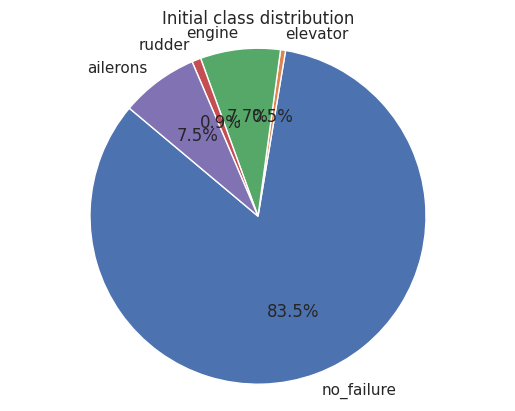

Classes size with respect to TRAIN size:
	 ->no_failure: 6237 (83.48%)
	 ->elevator: 36 (0.48%)
	 ->engine: 575 (7.70%)
	 ->rudder: 65 (0.87%)
	 ->ailerons: 558 (7.47%)


In [17]:
# Ok now run DWT_SMOT on all the minority classes... But how do we define minority ?
# Easy, with counter and percentages :)

# First lets plot a piechart:
from collections import Counter
import matplotlib.pyplot as plt

def plotPie(cDistribution, title):
  sizes, labels = [], []
  for item in cDistribution.items():
    labels.append(item[0])
    sizes.append(item[1])

  plt.pie(sizes,  labels=labels, autopct='%1.1f%%', startangle=140)
  plt.title(title)

  plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
  plt.show()

# Obviusly get the distribution of the on the train y (right Alberto?)
cDistrubution = Counter(y_train.tolist())
cDistribution = {classToString[item[0]]:item[1] for item in cDistrubution.items()}
plotPie(cDistribution, "Initial class distribution")

lenDataset = y_train.shape[0]

# Also print them for fun
print("Classes size with respect to TRAIN size:")
for item in cDistribution.items():
  print(f"\t ->{item[0]}: {item[1]} ({float((item[1]/lenDataset)*100):.2f}%)")

# Get the distributions percentages to decide whether to use DWT_SMOTE or not
distribution = {stringToClass[item[0]]: item[1]/lenDataset for item in cDistribution.items()}


In [18]:
# Connect to google drive so we can save the new windows in a csv for each class
import os
from google.colab import drive
drive.mount('/content/drive')
!mkdir -p "/content/drive/My Drive/smoted_data"

Mounted at /content/drive


In [19]:
import os
import numpy as np

# Run DWT_SMOTE for all the classes that are considered a minority
minorityThreshold = 0.25
undersamplePercentage = 0.75
max_index = int(np.max(X_train.index.get_level_values('flight').to_numpy()))+1

dir = "/content/drive/My Drive/smoted_data"
new_X_train, new_y_train = None, []
n_classes = len(classToString)

# I don't know a good way to tune them
_N = {"no_failure": 0, "elevator": 800, "engine": 200, "rudder": 600, "ailerons": 200}
_k = {"no_failure": 0, "elevator": 6, "engine": 4, "rudder": 6, "ailerons": 4}

for item in distribution.items():
  indexes = [i for i, c in enumerate(y_train.tolist()) if c ==item[0]]
  N = _N[classToString[item[0]]]
  k = _k[classToString[item[0]]]

  if item[1]> minorityThreshold:
    print(f"->UNDERSAMPLING '{classToString[item[0]]}'")

    # Multiplier to make the the quantity of the oversampled
    # class equal to the ((1/n_classes)*100)% of the train dataset
    nSamples = int(cDistribution[classToString[item[0]]]*undersamplePercentage)

    # NB: we should add Tomek-links removal first, like in SMOTEN,
    # before randomly sampling to the desired percentage ...

    # Undersample the huge class :_)
    new_indexes = np.random.choice(a=indexes, size=nSamples, replace=False) # With no repetition !
    fX = X_train[X_train.index.get_level_values('flight').isin(new_indexes)]

    # Save the values as a csv
    fX.to_csv(os.path.join(dir, f"{item[0]}.csv"))

    # Save the new Dataframe and labels

    new_X_train = pd.concat([new_X_train, fX])
    new_y_train += [item[0] for _ in range(nSamples)]

  else:
    print(f"->DTW_SMOTE '{classToString[item[0]]}' N={N} k={k}")
    # SMOTE PARAMS:
    T =  pd.DataFrame(X_train[X_train.index.get_level_values('flight').isin(indexes)])

    # Run DTW_SMOTE
    sampler = DTW_SMOTE(T, N, k, start = max_index)
    fX, fy= sampler.run(item[0])

    # Save the values as a CSV
    fX.to_csv(os.path.join(dir, f"{item[0]}.csv"))

    # Save the values for X, y and the flight index counter
    new_X_train = pd.concat([new_X_train, fX])
    new_y_train += fy
    max_index += len(fy) +1


  print(f"\t-new_X_train length: {np.unique(new_X_train.index.get_level_values('flight').to_numpy()).shape[0]}")
  print(f"\t-new_y_train length: {len(new_y_train)}")
  assert np.unique(new_X_train.index.get_level_values('flight').to_numpy()).shape[0] == len(new_y_train), f"{classToString[item[0]]} not the same lenght"


->UNDERSAMPLING 'no_failure'
	-new_X_train length: 4677
	-new_y_train length: 4677
->DTW_SMOTE 'elevator' N=800 k=6
	-new_X_train length: 5001
	-new_y_train length: 5001
->DTW_SMOTE 'engine' N=200 k=4
	-new_X_train length: 6726
	-new_y_train length: 6726
->DTW_SMOTE 'rudder' N=600 k=6
	-new_X_train length: 7181
	-new_y_train length: 7181
->DTW_SMOTE 'ailerons' N=200 k=4
	-new_X_train length: 8855
	-new_y_train length: 8855


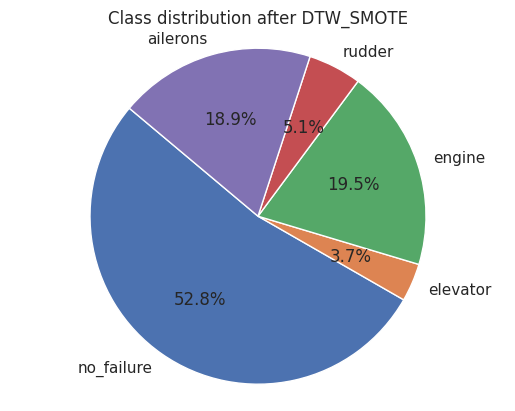

In [20]:
# Resave the values as nothing happened ( The new inputs )
X_train = new_X_train
y_train = np.array(new_y_train)

# Final class distribution
cDistrubution = Counter(y_train.tolist())
cDistribution = {classToString[item[0]]:item[1] for item in cDistrubution.items()}
plotPie(cDistribution, "Class distribution after DTW_SMOTE")

## Testing Models:

We choose to use three models (KNN, CNN, RNN), using the same pipeline, then we are showing the results with some metrics.

In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sktime.classification.model_selection import TSCGridSearchCV

#  Apply feature Masks to the inputs
X_train, X_test = X_train[feature_mask], X_test[feature_mask]

class_labels = np.array(list(classToString.values()))

### K-Nearest Neighbour (KNN)

**K-Nearest Neighbour (K-NN)** is a supervised machine learning algorithm employed for classification and regression tasks. An advantage of this model is that it is non-parametric (it doesn't make any assumptions about the data distribution) and so is widely disposable in real-life scenarios.

The algorithm operates on the principle of *similarity*, where it predicts the label or value of a new data point by considering the labels/values of its K nearest neighbors in the training dataset.

Steps of the algorithm:
1. select the optimal K
2. calculating distances
3. finding the nearest neighbors
4. voting for classification or taking average for regression

It's easy to implement and has few hyperparameters: the value of K and the choice of the distance metric.

<div style="text-align: center;">
  <img src="https://github.com/CristianMorasso/statistical_project/blob/master/imgs/KNNExample.png?raw=1" alt="KNN Example" style="width: 50%;"/>
  <p style="font-size: small;">Image source: <a href="https://www.geeksforgeeks.org/k-nearest-neighbours/" target="_blank">https://www.geeksforgeeks.org/k-nearest-neighbours/</a></p>
</div>

In [22]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from joblib import Parallel, delayed
import multiprocessing
print(f"n_cpus: {multiprocessing.cpu_count()}")

param_grid = {}

# Automatically do 5 K-Fold
grid_search_knn = TSCGridSearchCV(
    estimator=KNeighborsTimeSeriesClassifier(n_neighbors=5, distance='dtw', n_jobs=-1),
    param_grid=param_grid,
    scoring='accuracy'
)

grid_search_knn.fit(X_train, y_train)

best_params = grid_search_knn.best_params_
best_score = grid_search_knn.best_score_
print(f"Best parameters: {best_params}")
print(f"Best cross-validation accuracy: {best_score:.2f}")

y_pred_knn = grid_search_knn.predict(X_test)


n_cpus: 12
Best parameters: {}
Best cross-validation accuracy: 0.83


### Convolutional Neural Network (CNN)

**Convolutional Neural Networks (CNNs)** are a class of deep learning algorithms commonly used for processing and analyzing visual data, but they have been applied also to other types of data, like the time series.

The key concepts at the basis of CNN are:
- *convolutional layers*: they can be a lot and each of them learns to detect different features, based on different filters at different resolutions
- *relu*: activation function that leads to a faster learning by mapping the negative values to zero and maintaining the positive ones
- *pooling layers*: simplifies the output by a non-linear downsampling (average or max), reducing the number of parameters the network has to learn

<div style="text-align: center;">
  <img src="https://github.com/CristianMorasso/statistical_project/blob/master/imgs/CNNExample.png?raw=1" alt="CNN Example" style="width: 50%;"/>
  <p style="font-size: small;">Image source: <a href="https://it.mathworks.com/discovery/convolutional-neural-network.html" target="_blank">https://it.mathworks.com/discovery/convolutional-neural-network.html</a></p>
</div>

CNNs are suitable when you have a large amount of complex data, for example to learn the main features contained in an image, but also used with signals and time series.
Some application fields are: medical imaging, audio elaboration, object detection, generation of synthetic data, and many others.

In [23]:
from sktime.classification.deep_learning.cnn import CNNClassifier

param_grid = {
    "kernel_size": [3],
    "n_conv_layers": [3, 5],
    "batch_size": [8],
    "n_epochs": [75],
}

# Automatically do 5 K-Fold
grid_search_cnn = TSCGridSearchCV(
    estimator=CNNClassifier(avg_pool_size=1, loss='categorical_crossentropy'),
    param_grid=param_grid,
    scoring='accuracy',
    verbose=2
)

grid_search_cnn.fit(X_train, y_train)

best_params = grid_search_cnn.best_params_
best_score = grid_search_cnn.best_score_
print(f"Best parameters: {best_params}")
print(f"Best cross-validation accuracy: {best_score:.2f}")

y_pred_cnn = grid_search_cnn.predict(X_test)

<module 'multiprocessing' from '/usr/lib/python3.10/multiprocessing/__init__.py'>
Fitting 5 folds for each of 2 candidates, totalling 10 fits
222/222 [==============================] - 1s 2ms/step
[CV] END batch_size=8, kernel_size=3, n_conv_layers=3, n_epochs=75; total time= 3.8min
222/222 [==============================] - 0s 1ms/step
[CV] END batch_size=8, kernel_size=3, n_conv_layers=3, n_epochs=75; total time= 3.7min
222/222 [==============================] - 0s 2ms/step
[CV] END batch_size=8, kernel_size=3, n_conv_layers=3, n_epochs=75; total time= 3.7min
222/222 [==============================] - 0s 1ms/step
[CV] END batch_size=8, kernel_size=3, n_conv_layers=3, n_epochs=75; total time= 3.7min
222/222 [==============================] - 0s 1ms/step
[CV] END batch_size=8, kernel_size=3, n_conv_layers=3, n_epochs=75; total time= 3.7min
222/222 [==============================] - 0s 2ms/step
[CV] END batch_size=8, kernel_size=3, n_conv_layers=5, n_epochs=75; total time= 4.7min
222/22

### Recurrent Neural Network (RNN)

**Recurrent Neural Networks (RNNs)** are a class of neural networks designed for sequential data. Unlike traditional feedforward neural networks, RNNs have connections that form directed cycles, enabling them to maintain a "memory" of previous inputs in the sequence.

The most important feature in RNN is its *hidden state*, which remembers some information about a sequence until that moment. This state acts like a memory, allowing the net to remember the past information and use it to produce the next output.

<div style="text-align: center;">
  <img src="https://github.com/CristianMorasso/statistical_project/blob/master/imgs/RNNExample.png?raw=1" alt="RNN Example" style="width: 50%;"/>
  <p style="font-size: small;">Image source: <a href="https://www.geeksforgeeks.org/introduction-to-recurrent-neural-network/" target="_blank">https://www.geeksforgeeks.org/introduction-to-recurrent-neural-network/</a></p>
</div>

RNNs are suitable for capturing temporal dependencies and relationships in sequential data, making them effective for tasks where context over time is important.

In [24]:
from sktime.classification.deep_learning.rnn import SimpleRNNClassifier

param_grid = {
    "units": [4],
    "batch_size": [8],
    "n_epochs": [40],
}

# Automatically do 5 K-Fold
grid_search_rnn = TSCGridSearchCV(
    estimator=SimpleRNNClassifier(loss='categorical_crossentropy'),
    param_grid=param_grid,
    scoring='accuracy',
    verbose=2
)

grid_search_rnn.fit(X_train, y_train)

best_params = grid_search_rnn.best_params_
best_score = grid_search_rnn.best_score_
print(f"Best parameters: {best_params}")
print(f"Best cross-validation accuracy: {best_score:.2f}")

y_pred_rnn = grid_search_rnn.predict(X_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
222/222 [==============================] - 1s 2ms/step
[CV] END .................batch_size=8, n_epochs=40, units=4; total time= 3.3min
222/222 [==============================] - 1s 2ms/step
[CV] END .................batch_size=8, n_epochs=40, units=4; total time= 3.2min
222/222 [==============================] - 1s 2ms/step
[CV] END .................batch_size=8, n_epochs=40, units=4; total time= 3.2min
222/222 [==============================] - 1s 2ms/step
[CV] END .................batch_size=8, n_epochs=40, units=4; total time= 3.2min
222/222 [==============================] - 1s 2ms/step
[CV] END .................batch_size=8, n_epochs=40, units=4; total time= 3.2min
Best parameters: {'batch_size': 8, 'n_epochs': 40, 'units': 4}
Best cross-validation accuracy: 0.68
234/234 [==============================] - 1s 2ms/step


## Model comparison

K-Nearest Neighbor
Accuracy: 0.86

Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.91      0.92      1560
         1.0       0.25      0.40      0.31        10
         2.0       0.69      0.65      0.67       144
         3.0       0.71      0.71      0.71        17
         4.0       0.48      0.57      0.52       140

    accuracy                           0.86      1871
   macro avg       0.61      0.65      0.63      1871
weighted avg       0.87      0.86      0.87      1871

Convolutional Neural Network
Accuracy: 0.78

Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.82      0.87      1560
         1.0       0.07      0.10      0.08        10
         2.0       0.52      0.73      0.61       144
         3.0       0.31      0.53      0.39        17
         4.0       0.25      0.44      0.32       140

    accuracy                           0.78      1871
   

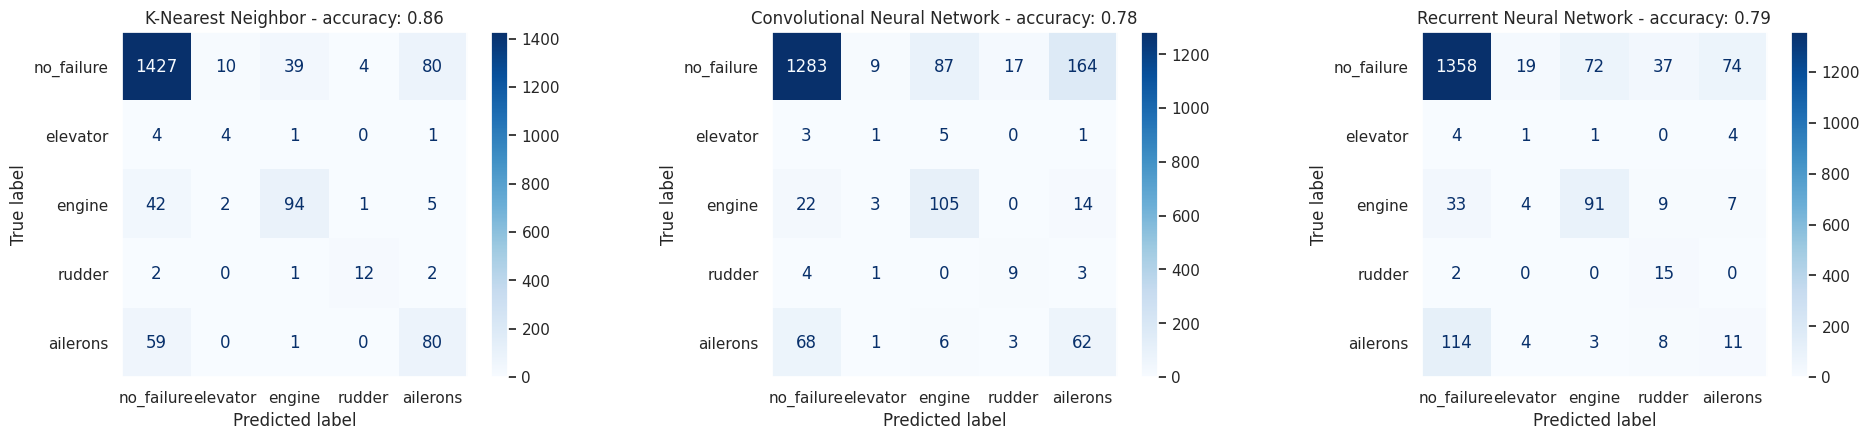

In [25]:
results = {'K-Nearest Neighbor': y_pred_knn, 'Convolutional Neural Network': y_pred_cnn, 'Recurrent Neural Network': y_pred_rnn}
fig,axs = plt.subplots(1,3, figsize=(20,5))

for (item, pred), ax in zip(results.items(), axs):
    print(item)
    acc = accuracy_score(y_test, pred)
    print(f"Accuracy: {acc:.2f}")

    report = classification_report(y_test, pred, zero_division = 0.0)
    print("\nClassification Report:\n", report)

    cm = confusion_matrix(y_test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    ax.set_title(f'{item} - accuracy: {acc:.2f}')
    ax.grid(False)

fig.tight_layout(pad=3.0)
plt.show()